# Global Sensitivity Analysis

This notebook aims to provide a better understanding of uncertainties and their potential impact on the outcomes of the IJssel River simulation model. This notebook offers a further understanding of how the uncertainties can influence the model outputs by performing Global Sensitivity Analysis. The method that was chosen was SOBOL as it offers great accuracy and is easy to generate from the ema workbench (SALib). 

To conduct a comprehensive analysis of uncertainties, we have selected specific model outputs based on our role as a Transport Company. The following outcomes of interest have been identified. For a more detailed explanation of the selected model outputs, please refer to the report [mention the name of the final PDF report].

| Outcome Name | Outcome Name in the Code        |
| --- |---------------------------------|
| Total Expected Number of Deaths | Total_Expected_Number_of_Deaths |
| Total Expected Annual Damage | Total_Expected_Annual_Damage    |
| Total Expected Annual Damage in Dike Ring 3 | A3_Expected_Annual_Damage       |
| Total Expected Annual Damage in Dike Ring 5 | A5_Expected_Annual_Damage       |
| Total Expected Annual Death in Dike Ring 3 | A3_Expected_Number_of_Deaths    |
| Total Expected Annual Death in Dike Ring 5 | A5_Expected_Number_of_Deaths    |

In Dimensional Stacking, we focus on the relationship of the following outcomes:
1. **Total Expected Number of Deaths**
2. **Total Expected Annual Damage**

As a transport company, our primary concern is to ensure the operability and safety of our business operations along the entire IJssel River. Therefore, it is crucial to understand the total expected number of deaths and the total expected annual damage, as these factors significantly influence the continuity and reliability of our transport activities. By focusing on these outcomes, we aim to make informed decisions to mitigate risks and ensure the sustainable operation of our transport network.



In [1]:
# Hide the warnings 
import warnings
warnings.filterwarnings('ignore')

-------------------
## 0. Imports and Setup

In [2]:
# Import necessary libraries for data manipulation, plotting, and sensitivity analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from the EMA Workbench for loading results and defining SALib problems
from ema_workbench import load_results
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [3]:
# Import essential classes and functions from the EMA Workbench
# EMA Workbench is used for performing Ensemble-based Modeling and Analysis
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation
dike_model, planning_steps = get_model_for_problem_formulation('All Dikes')

-------------------
## 1. Perform SALib Analysis

Next step is to perform Global Sensitivity by applying the SALib Analysis, which would return a dictionary with keys for the different relevant indicators (sobol indices of interest: first-order, total effects).

In [5]:
# Define the number of scenarios to run for the sensitivity analysis
n_scenarios = 64

# Define the policy to be used in the experiments, in this case, the "Base Case" policy
# This policy sets all lever values to 0
policies = [Policy("Base Case", **dict({L.name: 0 for L in dike_model.levers}))]

# Perform experiments using the MultiprocessingEvaluator to parallelize the execution
# The Sobol sampling method is used to generate the scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies=policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 2560 scenarios * 1 policies * 1 model(s) = 2560 experiments
100%|██████████████████████████████████████| 2560/2560 [01:54<00:00, 22.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Extract Results and Define the Problem for SALib Analysis:

In [7]:
# Extract the experiments and outcomes from the results obtained from the evaluator
experiments, outcomes = results
# Define the problem for the SALib analysis, specifying the uncertainties involved
problem = get_SALib_problem(dike_model.uncertainties)

-------------------
## 2. Visual Analysis

To visualize the first-order and total effects, along with their corresponding confidence intervals that were generated by the SALib Analysis, multiple plots were created for the following outcomes of interest:

1. Total Expected Number of Deaths
2. Total Expected Annual Damage
3. Total Expected Annual Damage in Dike Ring 3
4. Total Expected Annual Damage in Dike Ring 5
5. Total Expected Annual Death in Dike Ring 3
6. Total Expected Annual Death in Dike Ring 5

 Based on the transportation company’s mandate and debates, we grouped dike rings A3 and A5 as urban areas that have to be heightened and become the focus of further analysis to generate robust decision-making.

By creating these plots, we can gain a better understanding of the relationships and influences of the uncertainties on the desired outcomes.

### 2.1 Total Expected Number of Deaths

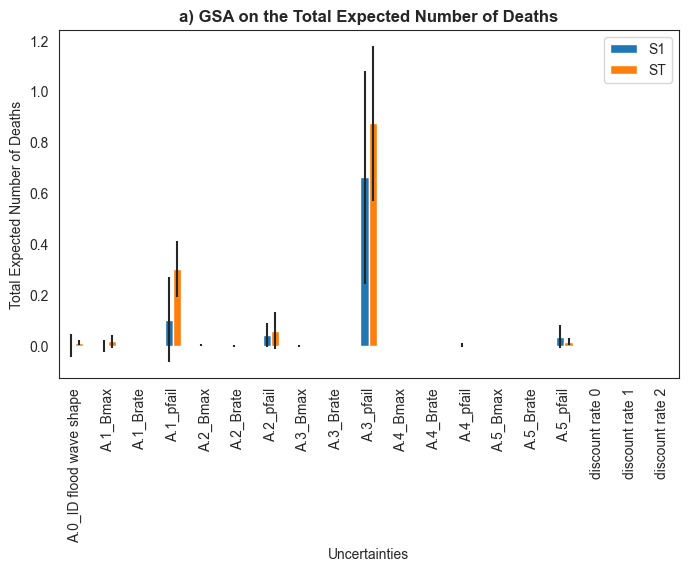

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from SALib.analyze import sobol

# Define the function to compute the range
def range_ptp(arr):
    return np.ptp(arr)

# Perform Sobol sensitivity analysis
Si = sobol.analyze(problem, outcomes["Total_Expected_Number_of_Deaths"], calc_second_order=True, print_to_console=False)

# Filter the scores
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

# Plotting
sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

# Graph setup
plt.title('a) GSA on the Total Expected Number of Deaths', fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Number of Deaths')
plt.savefig('./img/GSA_Total_Deaths.png')
plt.show()

The graph demonstrates the results of Sobol sensitivity analysis for Total Expected Number of Deaths, which indicates that certain uncertainties, particularly those related to "A3_pfail" and "A1_pfail" have the most significant impact on the total expected number of deaths, as indicated by their higher first-order (S1) and total-order (ST) sensitivity indices compared to other parameters.

### 2.2 Total Expected Annual Damage

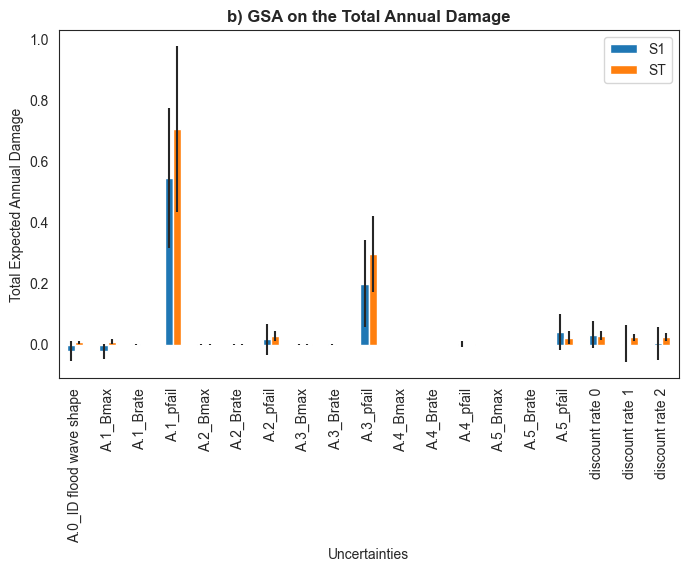

In [10]:
Si = sobol.analyze(problem, outcomes["Total_Expected_Annual_Damage"], calc_second_order=True, print_to_console=False)
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

#Graph setup
plt.title('b) GSA on the Total Annual Damage',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Annual Damage')
plt.savefig('./img/GSA_Total_Damages.png')
plt.show()

The results of Sobol sensitivity analysis for Total Expected Annual Damage indicates that certain uncertainties, particularly those related to "A1_pfail" and "A3_pfail" have the most significant impact on the total expected annual damage.

### 2.3 Total Expected Annual Damage in Dike Ring 3

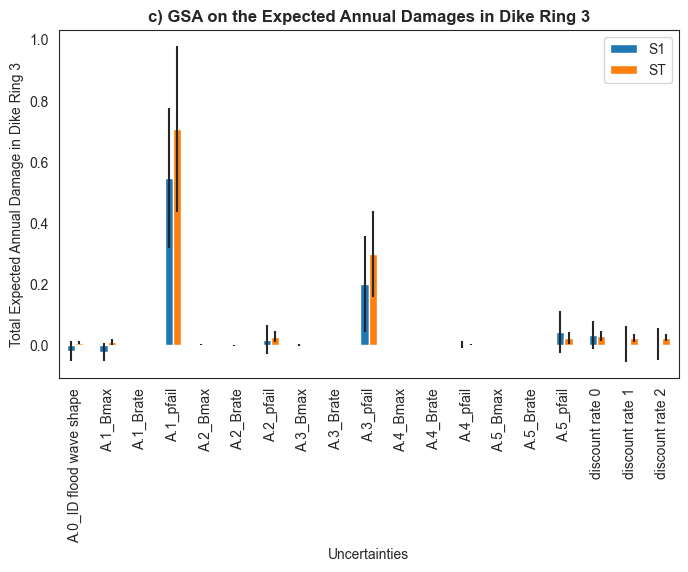

In [16]:
# Perform Sobol sensitivity analysis on the Total Expected Annual Damage outcome
# This analysis calculates first-order and total-order sensitivity indices
Si = sobol.analyze(problem, outcomes["Total_Expected_Annual_Damage"], calc_second_order=True, print_to_console=False)

# Filter the relevant sensitivity scores for plotting
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

# Set up the style for the seaborn plots
sns.set_style("white")

# Create a bar plot for the sensitivity indices with error bars
fig, ax = plt.subplots(1)
indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

#Graph setup
plt.title('c) GSA on the Expected Annual Damages in Dike Ring 3',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Annual Damage in Dike Ring 3')
plt.savefig('./img/GSA_Damages_A3.png')
plt.show()

The results of Sobol sensitivity analysis for Total Expected Annual Damage in Dike Ring 3 indicates that certain uncertainties, particularly those related to “A1_pfail” and “A3_pfail” have the most significant impact on the total expected annual damage in Dike Ring 3.

### 2.4 Total Expected Annual Damage in Dike Ring 5

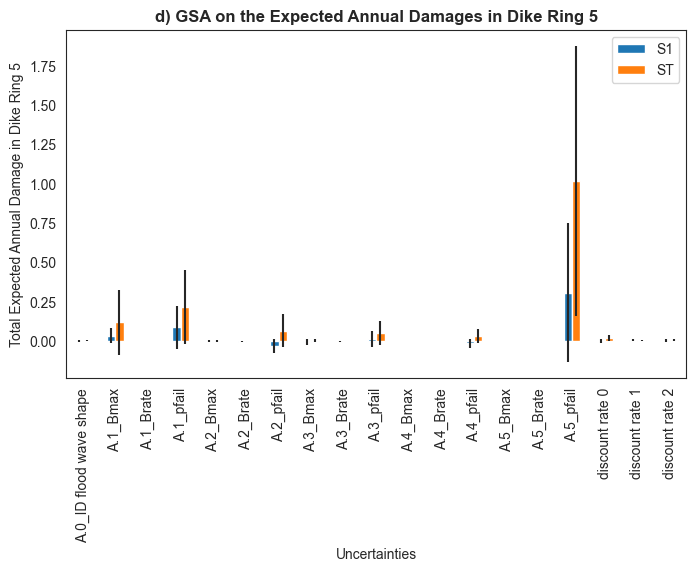

In [17]:
# Perform Sobol sensitivity analysis on the Expected Annual Damage outcome for Dike Ring 5
# This analysis calculates first-order and total-order sensitivity indices
Si = sobol.analyze(problem, outcomes["A5_Expected_Annual_Damage"], calc_second_order=True, print_to_console=False)

# Filter the relevant sensitivity scores for plotting
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

# Set up the style for the seaborn plots
sns.set_style("white")

# Create a bar plot for the sensitivity indices with error bars
fig, ax = plt.subplots(1)
indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

#Graph setup
plt.title('d) GSA on the Expected Annual Damages in Dike Ring 5',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Annual Damage in Dike Ring 5')
plt.savefig('./img/GSA_Damages_A5.png')
plt.show()

The results of Sobol sensitivity analysis for Total Expected Annual Damage in Dike Ring 5 indicates that certain uncertainties, particularly those related to “A5_pfail” have the most significant impact on the total expected annual damage in Dike Ring 5.

### 2.5 Total Expected Annual Death in Dike Ring 3

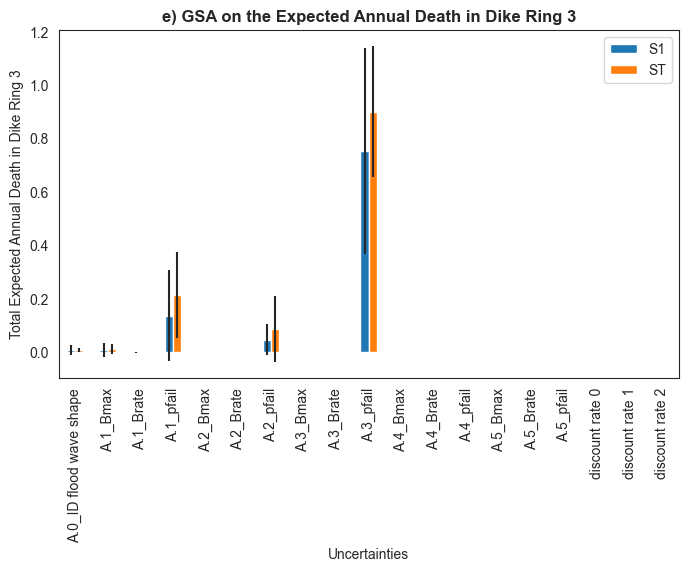

In [18]:
# Perform Sobol sensitivity analysis on the Expected Number of Deaths outcome for Dike Ring 3
# This analysis calculates first-order and total-order sensitivity indices
Si = sobol.analyze(problem, outcomes["A3_Expected_Number_of_Deaths"], calc_second_order=True, print_to_console=False)

# Filter the relevant sensitivity scores for plotting
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

# Set up the style for the seaborn plots
sns.set_style("white")

# Create a bar plot for the sensitivity indices with error bars
fig, ax = plt.subplots(1)
indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

#Graph setup
plt.title('e) GSA on the Expected Annual Death in Dike Ring 3',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Annual Death in Dike Ring 3')
plt.savefig('./img/GSA_Death_A3.png')
plt.show()

The results of Sobol sensitivity analysis for Total Expected Annual Deaths in Dike Ring 3 indicates that certain uncertainties, particularly those related to “A3_pfail” and “A1_pfail” have the most significant impact on the total expected annual deaths in Dike Ring 3.

### 2.6 Total Expected Annual Death in Dike Ring 5

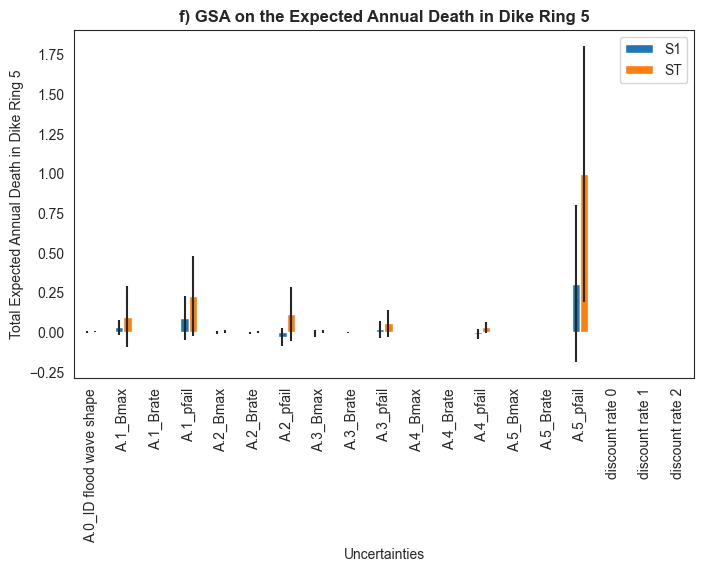

In [19]:
Si = sobol.analyze(problem, outcomes["A5_Expected_Number_of_Deaths"], calc_second_order=True, print_to_console=False)
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)

#Graph setup
plt.title('f) GSA on the Expected Annual Death in Dike Ring 5',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Total Expected Annual Death in Dike Ring 5')
plt.savefig('./img/GSA_Death_A5.png')
plt.show()

The results of Sobol sensitivity analysis for Total Expected Annual Deaths in Dike Ring 5 indicates that certain uncertainties, particularly those related to “A5_pfail” have the most significant impact on the total expected annual deaths in Dike Ring 5.